In [50]:
# imports
import matplotlib
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from random import randint
import random
import SimpleITK as sitk
from multi_slice_viewer import multi_slice_viewer
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv3D, MaxPooling3D, Dropout, Conv3DTranspose, UpSampling3D, concatenate, Cropping3D, Reshape, BatchNormalization
import keras.callbacks
from keras import backend as K
from keras import optimizers
from keras import regularizers
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical

# this part is needed if you run the notebook on Cartesius with multiple cores
n_cores = 32
config = tf.ConfigProto(intra_op_parallelism_threads=n_cores-1, inter_op_parallelism_threads=1, allow_soft_placement=True)
config.gpu_options.allow_growth = True               # added this
session = tf.Session(config=config)
K.set_session(session)
os.environ["OMP_NUM_THREADS"] = str(n_cores-1)
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

In [2]:
# Task03_liver dir in same directory as notebook
data_path = './Task03_Liver/'
print([file for file in os.listdir(data_path) if not file.startswith('.')])

['dataset.json', 'imagesTs', 'core.26753', 'imagesTr', 'Task09_Spleen', 'labelsTr']


In [3]:
# info about dataset in json file
with open(data_path + 'dataset.json') as f:
    d = json.load(f)
    print(d.keys())
    
    # paths to training set images with label
    train_paths = d['training']
    
    # paths to testset images with label
    test_paths = d['test'] 

dict_keys(['numTest', 'modality', 'test', 'numTraining', 'training', 'reference', 'release', 'tensorImageSize', 'name', 'licence', 'labels', 'description'])


In [4]:
# print some stuff about the dataset
print(d['tensorImageSize'])
print(d['modality'])
print(d['labels'])
print(d['numTraining'])
print(d['numTest']) 

3D
{'0': 'CT'}
{'0': 'background', '2': 'cancer', '1': 'liver'}
131
70


In [5]:
# change to data dir 
os.chdir(data_path)
print(os.getcwd())

/nfs/home1/tdado/project/Task03_Liver


# Visualize images in the train set

In [56]:
# load images and labels, cant load in memory, have to make a generator or something
n = 5
train_imgs = [sitk.ReadImage(train_instance['image']) for train_instance in train_paths[100:100+n]]
train_lbls = [sitk.ReadImage(train_instance['label']) for train_instance in train_paths[100:100+n]]

In [7]:
# print size of imgs
for img in train_imgs:
    print(img.GetSize())

(512, 512, 333)
(512, 512, 987)
(512, 512, 188)
(512, 512, 761)
(512, 512, 122)


In [8]:
# Resample, same pixel spacing for each img in x, y, z direction
for img in train_imgs:
    img.SetSpacing((1,1,1))

# same for the labels
for lbs in train_lbls:
    lbs.SetSpacing((1,1,1))

In [9]:
# class for datasets
class DataSet:
    
    def __init__(self, imgs, lbls=None):
        self.imgs = imgs
        self.lbls = lbls
    
    def get_lenght(self):
        return len(self.imgs)
    
    def show_image(self, i):
        if self.lbls != None: 
            plt.rcParams['figure.figsize'] = [8, 8]
            multi_slice_viewer(self.imgs[i], view='axial', overlay_1=self.lbls[i], overlay_1_thres=1, 
                   overlay_2=self.lbls[i], overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)
        else:
            plt.rcParams['figure.figsize'] = [8, 8]
            multi_slice_viewer(self.imgs[i], view='axial')  

<IPython.core.display.Javascript object>


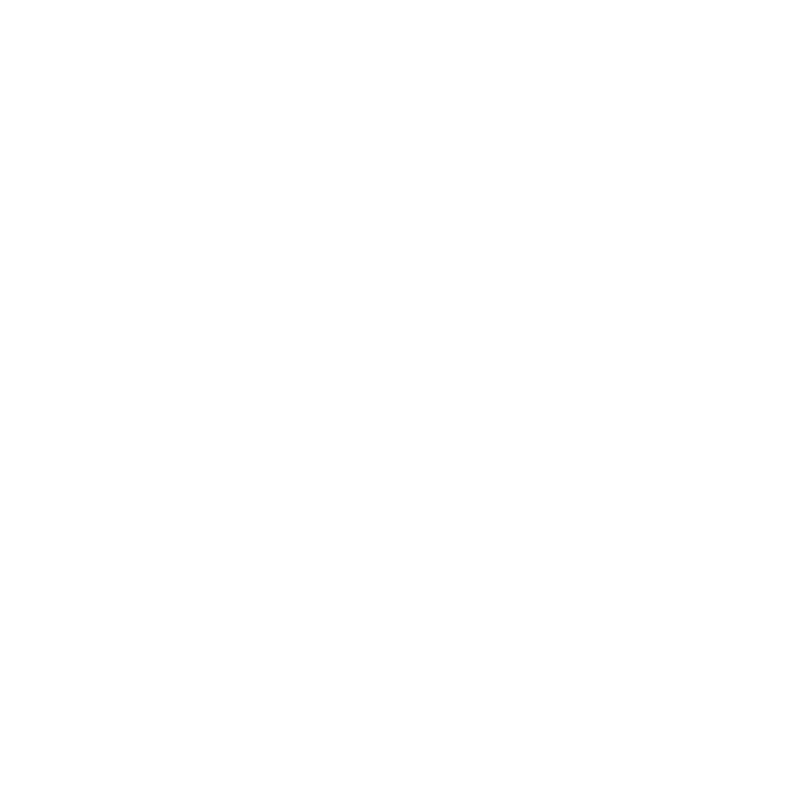

In [10]:
# make a small data set of training images, as numpy
np_train_imgs = [sitk.GetArrayFromImage(i) for i in train_imgs]
np_train_lbls = [sitk.GetArrayFromImage(i) for i in train_lbls]
train_set = DataSet(np_train_imgs, np_train_lbls)
train_set.show_image(0)

# Patch extractor
We re-use the patch extractor from assignment 7, but modify it to get 3D patches from a 3D image.
We can add augmentations later in the patch extractor. Image intensity is normalized to [0, 1]. 
Note the extra dimension in the shape of patch_out and target_out. This doesn't work if the patch size doesn't fit in the image.

In [11]:
class PatchExtractor:

    def __init__(self, patch_size):
        self.patch_size = patch_size 
    
    def get_patch(self, image, label):
        ''' 
        Get a 3D patch of patch_size from 3D input image, along with corresponding 3D label map.
        This function works with image size >= patch_size, and pick random location of the patch inside the image.   
        image: a numpy array representing the input image
        label: a numpy array representing the labels corresponding to input image
        '''
        
        px = self.patch_size[0]
        py = self.patch_size[1]
        pz = self.patch_size[2]
        
        # pick a random location, from which we can get a patch with patch_size, without going out of bounds
        dims = image.shape           
        r = randint(0, dims[0] - px)
        c = randint(0, dims[1] - py)
        d = randint(0, dims[2] - pz)
        
        patch  = image[r:r+px, c:c+py, d:d+pz].reshape(px, py, pz, 1)
        target = label[r:r+px, c:c+py, d:d+pz].reshape(px, py, pz, 1)

        # normalize image intensity to range [0., 1.]        
        patch = (patch - np.min(patch)) / np.ptp(patch)     
            
        return patch, target

(116, 132, 132, 1)
(116, 132, 132, 1)


<IPython.core.display.Javascript object>


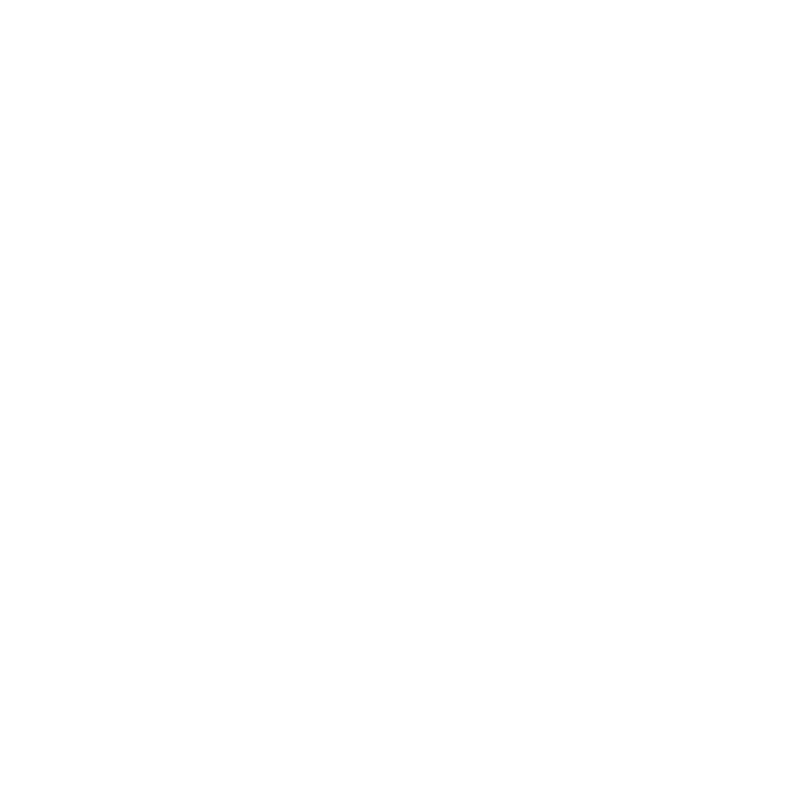

In [12]:
# get an image and a label from our train set
image = train_set.imgs[0]
label = train_set.lbls[0]

# test PatchExtractor
patch_size = (116, 132, 132)
patch_extractor = PatchExtractor(patch_size=patch_size)

# lets check some patches
patch, target = patch_extractor.get_patch(image, label)

print(patch.shape)
print(target.shape)

# show patch
plt.rcParams['figure.figsize'] = [8, 8]            
multi_slice_viewer(patch.reshape(patch_size), view='axial', overlay_1=target.reshape(patch_size), overlay_1_thres=1, 
                   overlay_2=target.reshape(patch_size), overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)

# Batch creator
Lets also reuse the batch creator from assignment 7. We are going to use valid convolutions, which means the output of our network will be smaller than the input. 

In [13]:
class BatchCreator:
    
    def __init__(self, patch_extractor, dataset, target_size):
        self.patch_extractor = patch_extractor
        self.target_size = target_size # size of the output, can be useful when valid convolutions are used        
        self.imgs = dataset.imgs
        self.lbls = dataset.lbls                
        self.n = len(self.imgs)
        self.patch_size = self.patch_extractor.patch_size
    
    def create_image_batch(self, batch_size):
        '''
        returns a single (batch of?) patches (x) with corresponding labels (y) in one-hot structure
        '''
        x_data = np.zeros((batch_size, *self.patch_extractor.patch_size, 1))  # 1 channel (??)
        y_data = np.zeros((batch_size, *self.target_size, 3)) # one-hot encoding with 3 classes
        
        for i in range(0, batch_size):
        
            random_index = np.random.choice(len(self.imgs))                   # pick random image
            img, lbl = self.imgs[random_index], self.lbls[random_index]       # get image and segmentation map
            patch_img, patch_lbl = self.patch_extractor.get_patch(img, lbl)   # when image size is equal to patch size, this line is useless...
        
            # crop labels based on target_size           
            ph = (self.patch_extractor.patch_size[0] - self.target_size[0]) // 2       # // : floor division
            pw = (self.patch_extractor.patch_size[1] - self.target_size[1]) // 2
            pd = (self.patch_extractor.patch_size[2] - self.target_size[2]) // 2
            
            # take the cropped patch, it contains labels with values 0,1,2
            cropped_patch = patch_lbl[ph:ph+self.target_size[0], pw:pw+self.target_size[1], pd:pd+self.target_size[2]].squeeze() 
            
            # instead of 0,1,2 label values we want categorical/onehot => 0: [1, 0, 0], 1: [0, 1, 0], 2: [0, 0, 1]
            onehot = to_categorical(cropped_patch, num_classes=3)
            
            x_data[i, :, :, :, :] = patch_img
            y_data[i, :, :, :, :] = onehot
        
        return (x_data.astype(np.float32), y_data.astype(np.float32))
    
    def get_image_generator(self, batch_size):
        '''returns a generator that will yield image-batches infinitely'''
        while True:
            yield self.create_image_batch(batch_size)

# 3D UNet Model
Start with this model, we can adapt this later if needed. Build like the net from: 
3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation. Ozgun Cicek et al, 2016.

In [30]:
# make block of two convolve3D's
def unet_block(inputs, n_filters, padding, up_conv=False, batchnorm=False):
    # 3d convolve, 32 3x3x3 filters 
    c1 = Conv3D(n_filters, (3,3,3), activation='relu', padding=padding)(inputs)
    if batchnorm:
        c1 = BatchNormalization()(c1)
    
    # up conv (normal conv in the expanding path) has same number of filters twice
    if up_conv:
        c2 = Conv3D(n_filters, (3, 3, 3), activation='relu', padding=padding)(c1)
    else:          # normal convs have twice the filters in the second conv
        c2 = Conv3D(n_filters*2, (3, 3, 3), activation='relu', padding=padding)(c1)
        
    if batchnorm:
        c2 = BatchNormalization()(c2)
    
    return c2

In [31]:
# 3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation. Ozgun Cicek et al, 2016.
def build_unet_3d(initial_filters, padding, batchnorm=True):
    
    ## CONTRACTING PATH

    # (spac_dim_1, space_dim_2, space_dim_3, channels)
    inputs = Input(shape=(116, 132, 132, 1))

    # First conv pool, 32 filters and 64 filters    
    block_1    = unet_block(inputs, initial_filters, padding=padding, batchnorm=batchnorm) 
    max_pool_1 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_1)  # 2×2×2 max pooling with strides two
                                                                        # needs even spacial_dimensions as input
    # second conv pool, 64 filters, 128 filters    
    block_2    = unet_block(max_pool_1, initial_filters*2, padding=padding, batchnorm=batchnorm)
    max_pool_2 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_2)
    
    # third conv pool, 128 filters, 256 filters    
    block_3    = unet_block(max_pool_2, initial_filters*4, padding=padding, batchnorm=batchnorm)
    max_pool_3 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_3)
    
    # just a conv block without maxpooling, 256 filters and 512 filters
    conv_4     = unet_block(max_pool_3, initial_filters*8, padding=padding, batchnorm=batchnorm)
    
    ## EXPANDING PATH   
    
    #TODO: check Conv3DTranspose correctly applied
    
    # round 1
    up_conv_3  = Conv3DTranspose(16*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(conv_4)
    crop_3     = Cropping3D(cropping=4)(block_3) 
    concat_3   = concatenate([crop_3, up_conv_3])  
    up_block_3 = unet_block(concat_3, 8*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # round 2
    up_conv_2  = Conv3DTranspose(8*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(up_block_3) 
    crop_2     = Cropping3D(cropping=16)(block_2) 
    concat_2   = concatenate([crop_2, up_conv_2])  
    up_block_2 = unet_block(concat_2, 4*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # round 3
    up_conv_1  = Conv3DTranspose(4*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(up_block_2) 
    crop_1     = Cropping3D(cropping=40)(block_1) 
    concat_1   = concatenate([crop_1, up_conv_1])  
    up_block_1 = unet_block(concat_1, 2*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # finish with 1x1x1 conv, 3 filters, # labels, softmax or ReLU?
    finish = Conv3D(3, (1,1,1), activation='softmax', padding=padding)(up_block_1)
    
    model = Model(inputs, finish) 
    print(model.summary(line_length=150))
    
    return model

In [32]:
unet_3d = build_unet_3d(initial_filters=32, padding='valid')

______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_3 (InputLayer)                             (None, 116, 132, 132, 1)         0                                                                   
______________________________________________________________________________________________________________________________________________________
conv3d_31 (Conv3D)                               (None, 114, 130, 130, 32)        896               input_3[0][0]                                     
______________________________________________________________________________________________________________________________________________________
batch_normalization_1 (BatchNormalization)       (None, 114, 130, 130, 32)        128         

In [33]:
# Not sure how this still isn't exactly the same parameters as the paper (19,069,955). Close enough tho.

## Split data into train and val

In [60]:
validation_percent = 0.2 # coefficient to define validation dataset (value between 0 and 1)
n_validation_imgs = int(validation_percent * len(train_imgs))

# use the first images as validation
validation_dataset = DataSet(train_imgs[:n_validation_imgs], train_lbls[:n_validation_imgs])

# the rest as training
training_dataset = DataSet(train_imgs[n_validation_imgs:], train_lbls[n_validation_imgs:])

# test dataset
# test_dataset = DataSet(test_imgs)

n_tra_imgs = training_dataset.get_lenght()
n_val_imgs = validation_dataset.get_lenght()
# n_tes_imgs = test_dataset.get_lenght()

print('{} training images'.format(n_tra_imgs))
print('{} validation images'.format(n_val_imgs))
# print('{} test images'.format(n_tes_imgs))

4 training images
1 validation images


## Now we compile the model and train the network 

In [34]:
# define parameters for the batch creator
target_size = (28, 44, 44)    # output size, smaller since valid convolutions are used
batch_size = 2                # number of patches in a mini-batch

# initialize patch generator and batch creator
patch_generator = PatchExtractor(patch_size)
batch_generator = BatchCreator(patch_generator, train_set, target_size=target_size)

# get one minibatch
x_data, y_data = batch_generator.create_image_batch(batch_size)

print('xdata has shape: {}'.format(x_data.shape))
print("(batch, d, h, w, channels)")
print('ydata has shape: {}'.format(y_data.shape))
print("(batch, d, h, w, label)")

xdata has shape: (2, 116, 132, 132, 1)
(batch, d, h, w, channels)
ydata has shape: (2, 28, 44, 44, 3)
(batch, d, h, w, label)


In [37]:
learning_rate   = 0.01
optimizer       = SGD(lr=learning_rate, momentum=0.9, nesterov=True)
loss            = 'categorical_crossentropy'
steps_per_epoch = 1
epochs          = 3

image_generator = batch_generator.get_image_generator(batch_size)

# compile model
unet_3d.compile(optimizer=optimizer, loss=loss)

# train the model
hist = unet_3d.fit_generator(generator=image_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=epochs, 
                    verbose=1)

Epoch 1/3
1/1 [==============================] - 32s 32s/step - loss: 0.2016
Epoch 2/3
1/1 [==============================] - 25s 25s/step - loss: 0.3870
Epoch 3/3
1/1 [==============================] - 25s 25s/step - loss: 0.2003


In [21]:
print('Shape of input: {}'.format(x_data.shape))
print('Shape of true labels: {}'.format(y_data.shape))
print('Occuring values in true labels: {}'.format(np.unique(y_data)))
print('Max of input: {}'.format(np.max(x_data)))
print('Min of input: {}'.format(np.min(x_data)))

Shape of input: (2, 116, 132, 132, 1)
Shape of true labels: (2, 28, 44, 44, 3)
Occuring values in true labels: [0. 1.]
Max of input: 1.0
Min of input: 0.0


1.0839608

In [38]:
print(hist.history)

{'loss': [0.20155611634254456, 0.3870394825935364, 0.20027628540992737]}


<IPython.core.display.Javascript object>


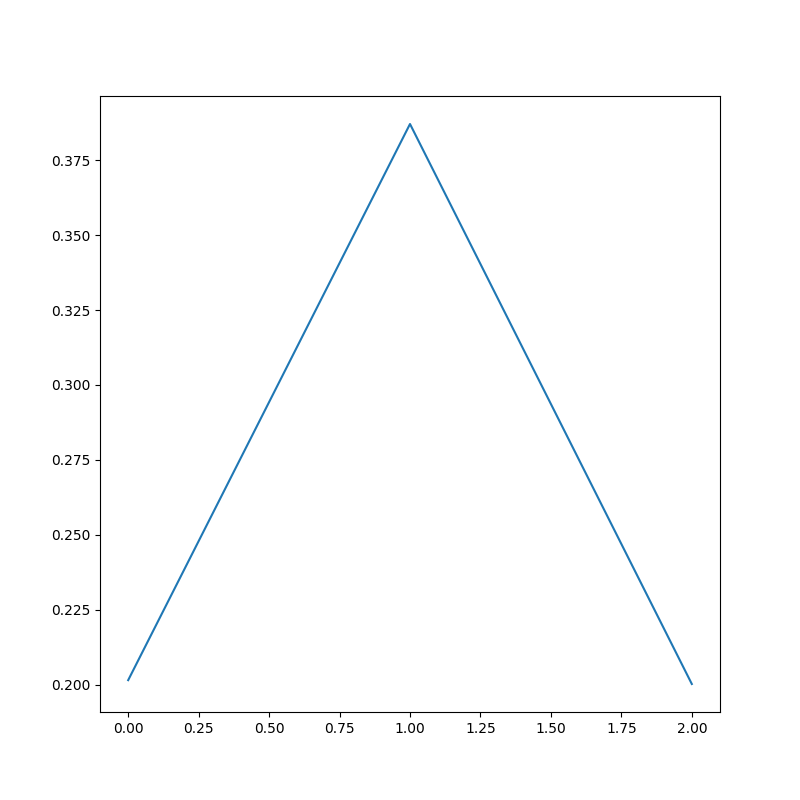

In [44]:
plt.figure()
plt.plot(range(0,3), hist.history['loss'])
plt.show()

## TODO: 
1. train network and plot loss
2. add dice loss
3. full segmentation function of image (hester)
5. shuffle data?